# Classifying Financial complaints with LLMs.


This project proposes developing an AI classification model using a pre-trained Large Language Model (LLM), fine-tuned with industry-specific complaint datasets. The model will be trained to understand and accurately classify customer complaints across various categories of Products (e.g. debt collection, credit card, checking accounts) and Issues (e.g.  Incorrect information on your report,  Improper use of your report,  Attempts to collect debt not owed, and account management). The model will classify the complaint to help route to the relevant department for its attention, making the resolution process faster and improving response times.

#**Part 1: Exploratory Analysis**

## 1.1 Obtaining financial data

The project will utilize a dataset of customer complaints from the financial sector, containing labeled data across various complaint types. This dataset will help to evaluate the model accuracy classifying complaints based on natural language. We will use a pre-existing dataset from the Consumer Financial Protection Bureau’s (CFPB) complaint database, ensuring coverage of diverse complaint types such as fraud, regulatory issues, billing disputes, and more.

Dataset reference: https://www.consumerfinance.gov/data-research/consumer-complaints/search/?date_received_max=2024-10-05&date_received_min=2024-04-05&page=1&searchField=all&size=25&sort=created_date_desc&tab=List

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=586310199198ea79078b39c5fb8f7cda1b7da00c1356189e5f859142b311387c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
import zipfile

# Step 1: Download the dataset
url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'
wget.download(url, 'complaints.csv.zip')

# Step 2: Unzip the file
with zipfile.ZipFile('complaints.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Step 3: Check if the file has been extracted
import os
print("Extracted files:", os.listdir())


Extracted files: ['.config', 'complaints.csv.zip', 'complaints.csv', 'sample_data']


In [ ]:
import pandas as pd
df = pd.read_csv('complaints.csv')

##  1.2 Data Cleaning

We cleaned and filtered the dataset by first visualizing missing values, then dropping rows with missing data in key complaint fields and removing irrelevant columns.

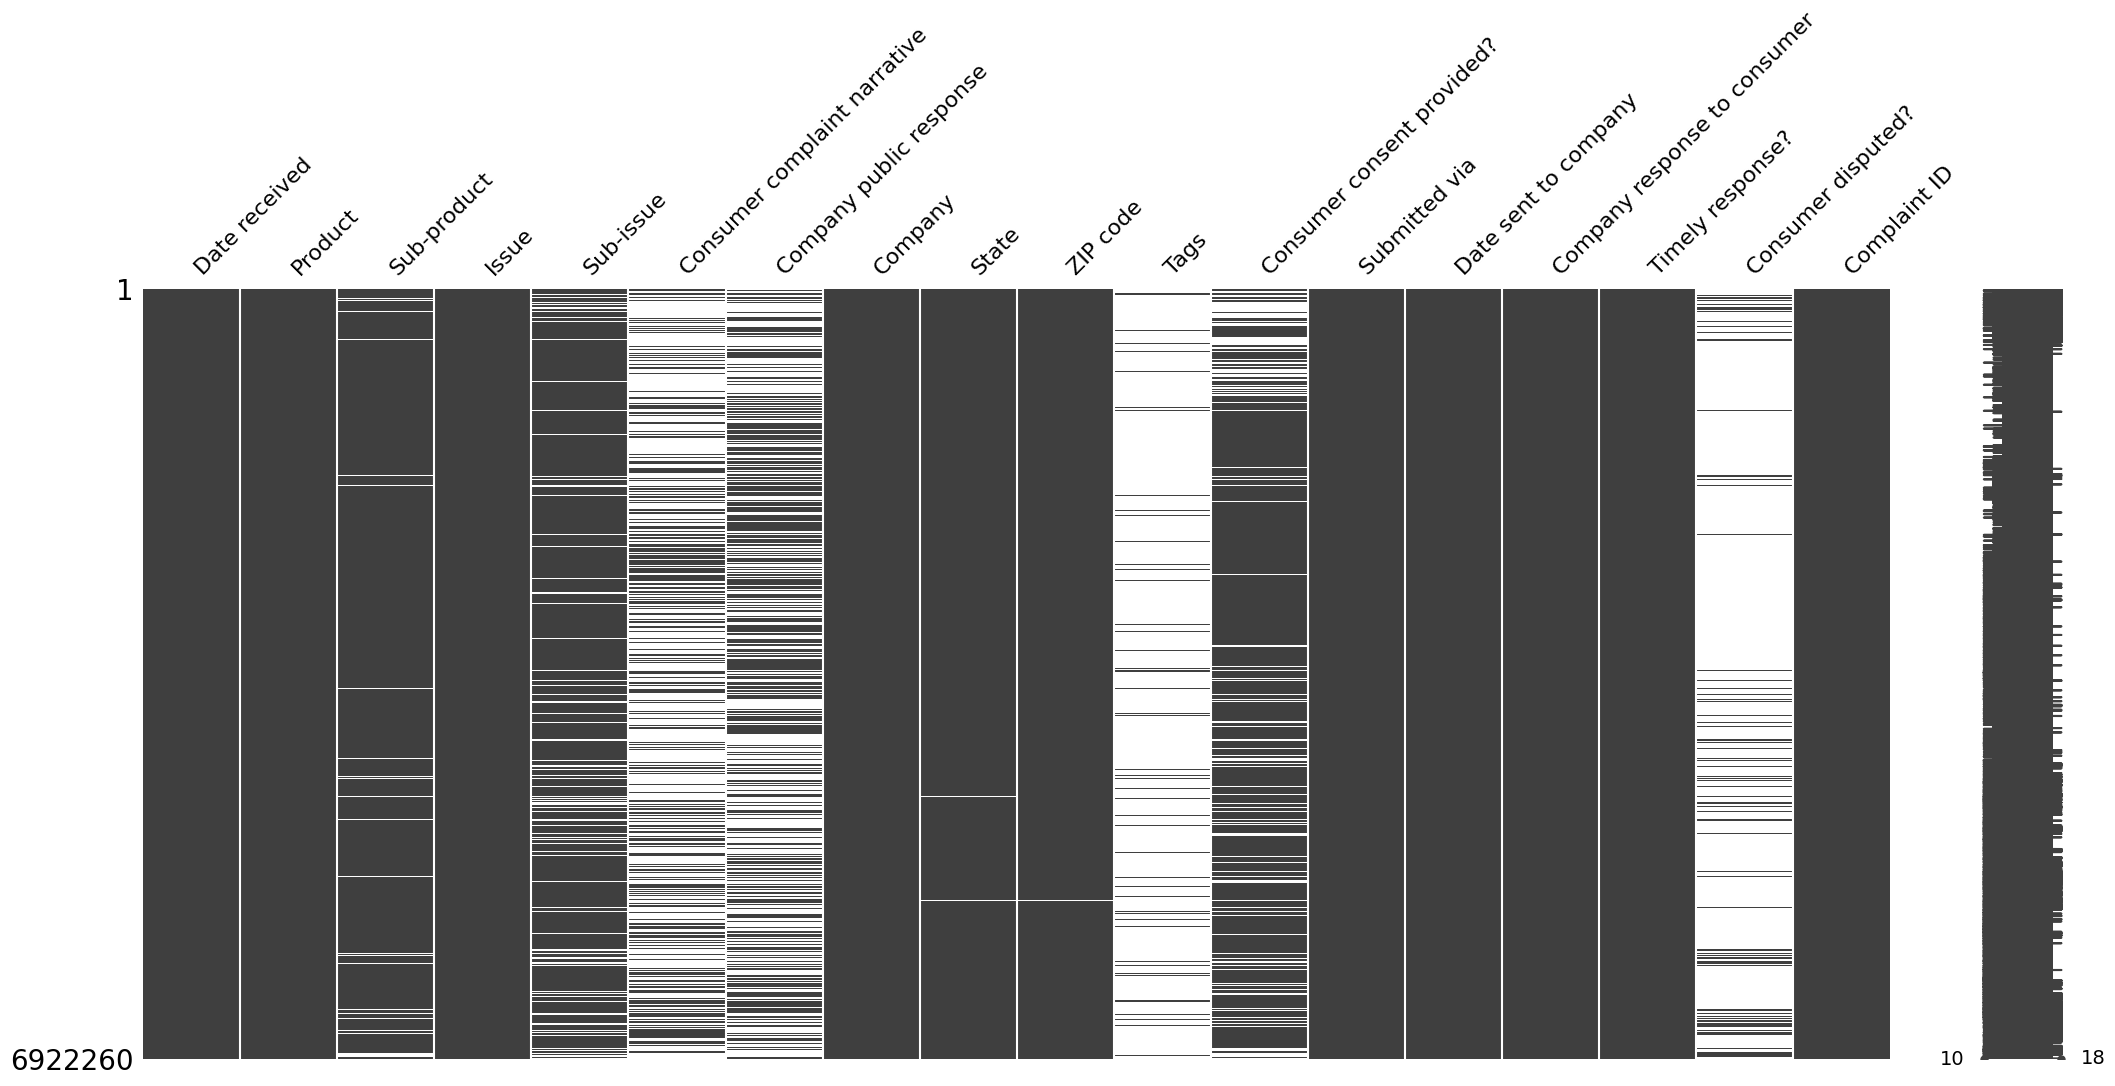

In [ ]:
import missingno as msno
msno.matrix(df);

In [ ]:
df = df.dropna(subset=['Consumer complaint narrative', 'Sub-product', 'Issue'])

In [ ]:
df = df.drop(columns=[
    'Company public response',
    'State',
    'ZIP code',
    'Tags',
    'Consumer consent provided?',
    'Submitted via',
    'Company response to consumer',
    'Consumer disputed?',
])

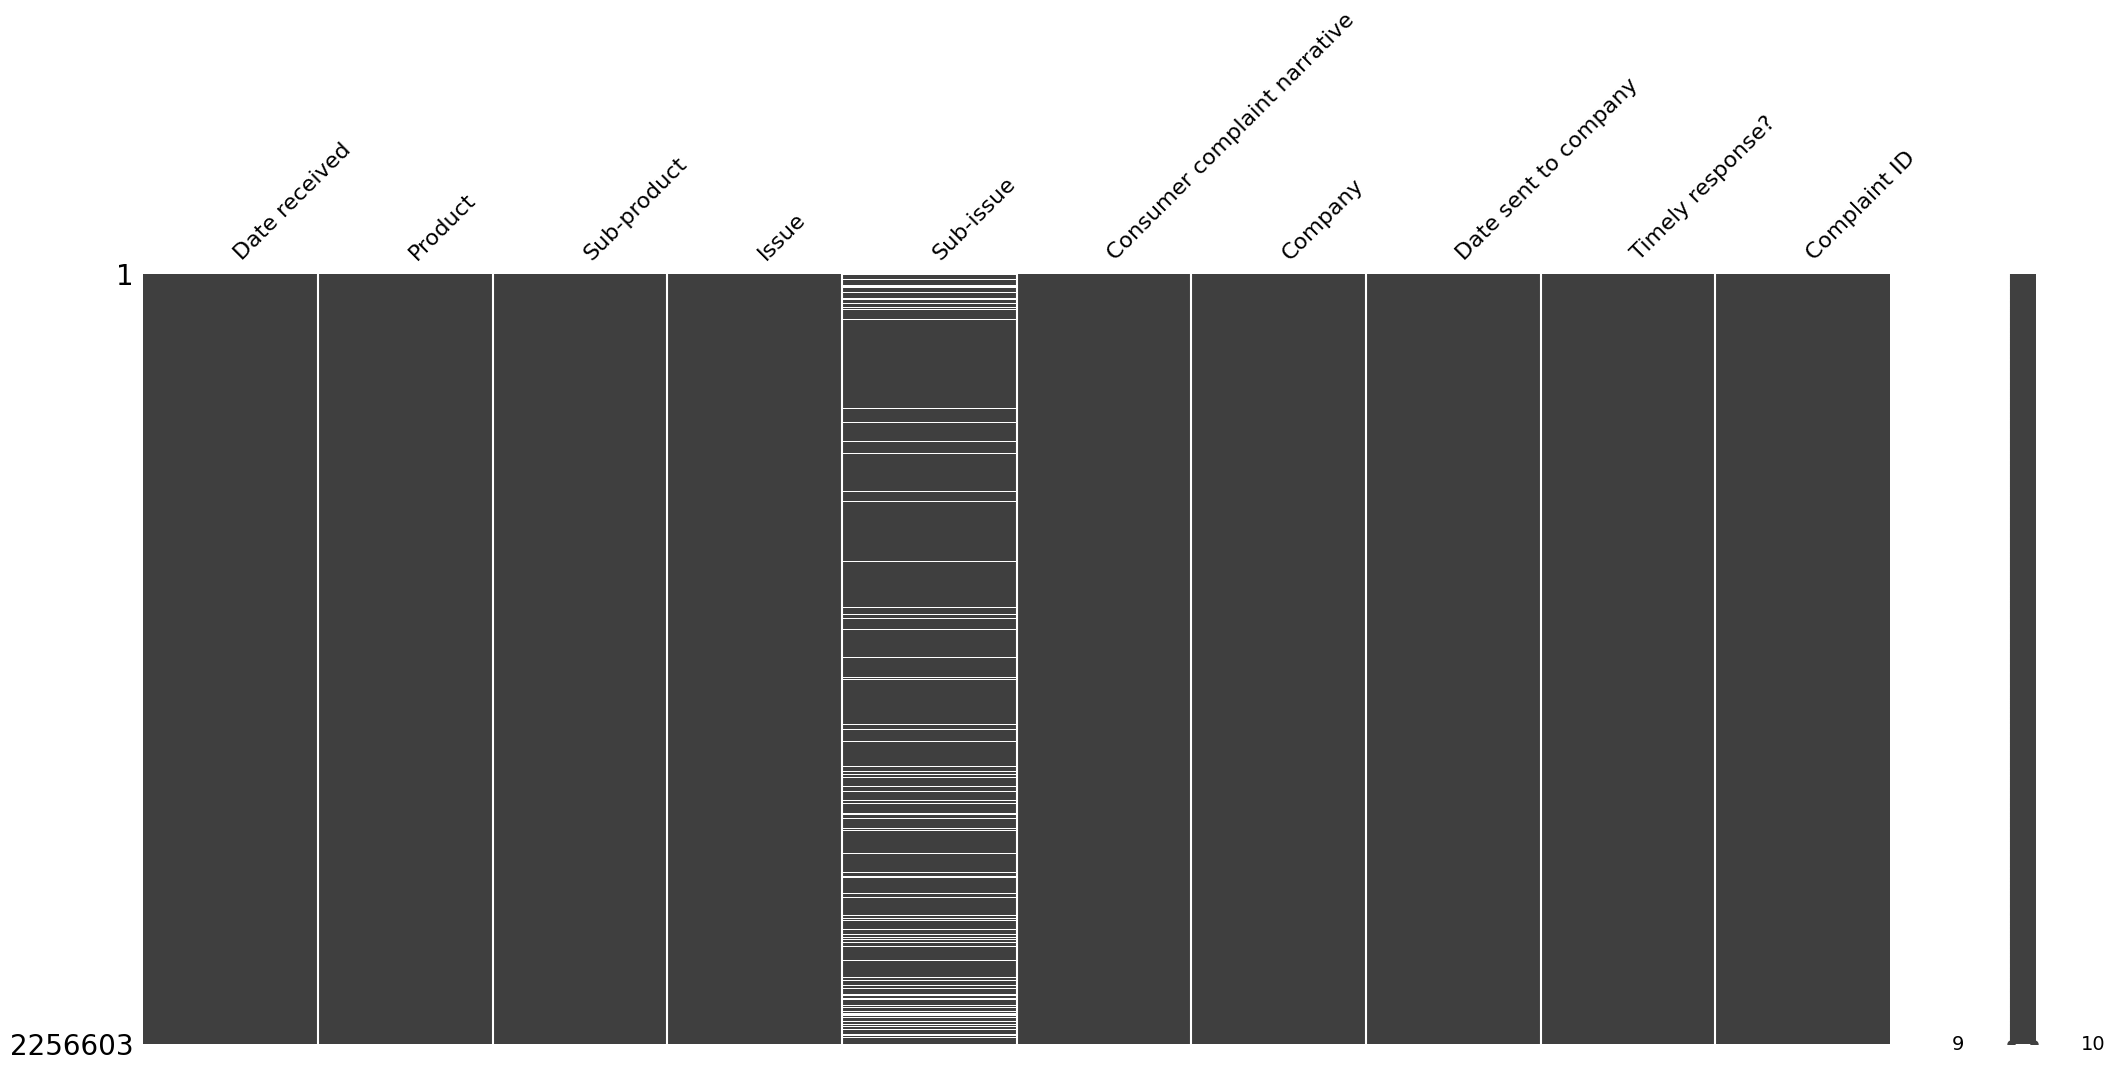

In [ ]:
import missingno as msno
msno.matrix(df);

In [ ]:
df = df.drop(columns=[
     'Sub-issue',
])

We converts the date received column to a datetime format, then filters the dataset to include only records within the specified date range from April to October 2024.

In [ ]:
df['Date received'] = pd.to_datetime(df['Date received'])

#date range
start_date = "2024-04-05"
end_date = "2024-10-05"

# Filter the dataset based on the date range
df1 = df[(df['Date received'] >= start_date) & (df['Date received'] <= end_date)]

# Display the filtered DataFrame
df1.head(5)

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,Date sent to company,Timely response?,Complaint ID
710,2024-08-12,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,I am contacting you regarding fraudulent perso...,"EQUIFAX, INC.",2024-08-12,Yes,9767785
851,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Formal Complaint Regarding Inaccurate Reportin...,Experian Information Solutions Inc.,2024-07-24,Yes,9604923
1087,2024-09-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Under 15 USC 1681i ( a ) ( 1 ) ( A ) subject t...,Experian Information Solutions Inc.,2024-09-20,Yes,10188781
2303,2024-09-25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,XX/XX/XXXX Subject : Complaint Regarding Inacc...,Experian Information Solutions Inc.,2024-09-25,Yes,10233037
2330,2024-10-02,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,The presence of this account has caused me sig...,Experian Information Solutions Inc.,2024-10-02,Yes,10314140


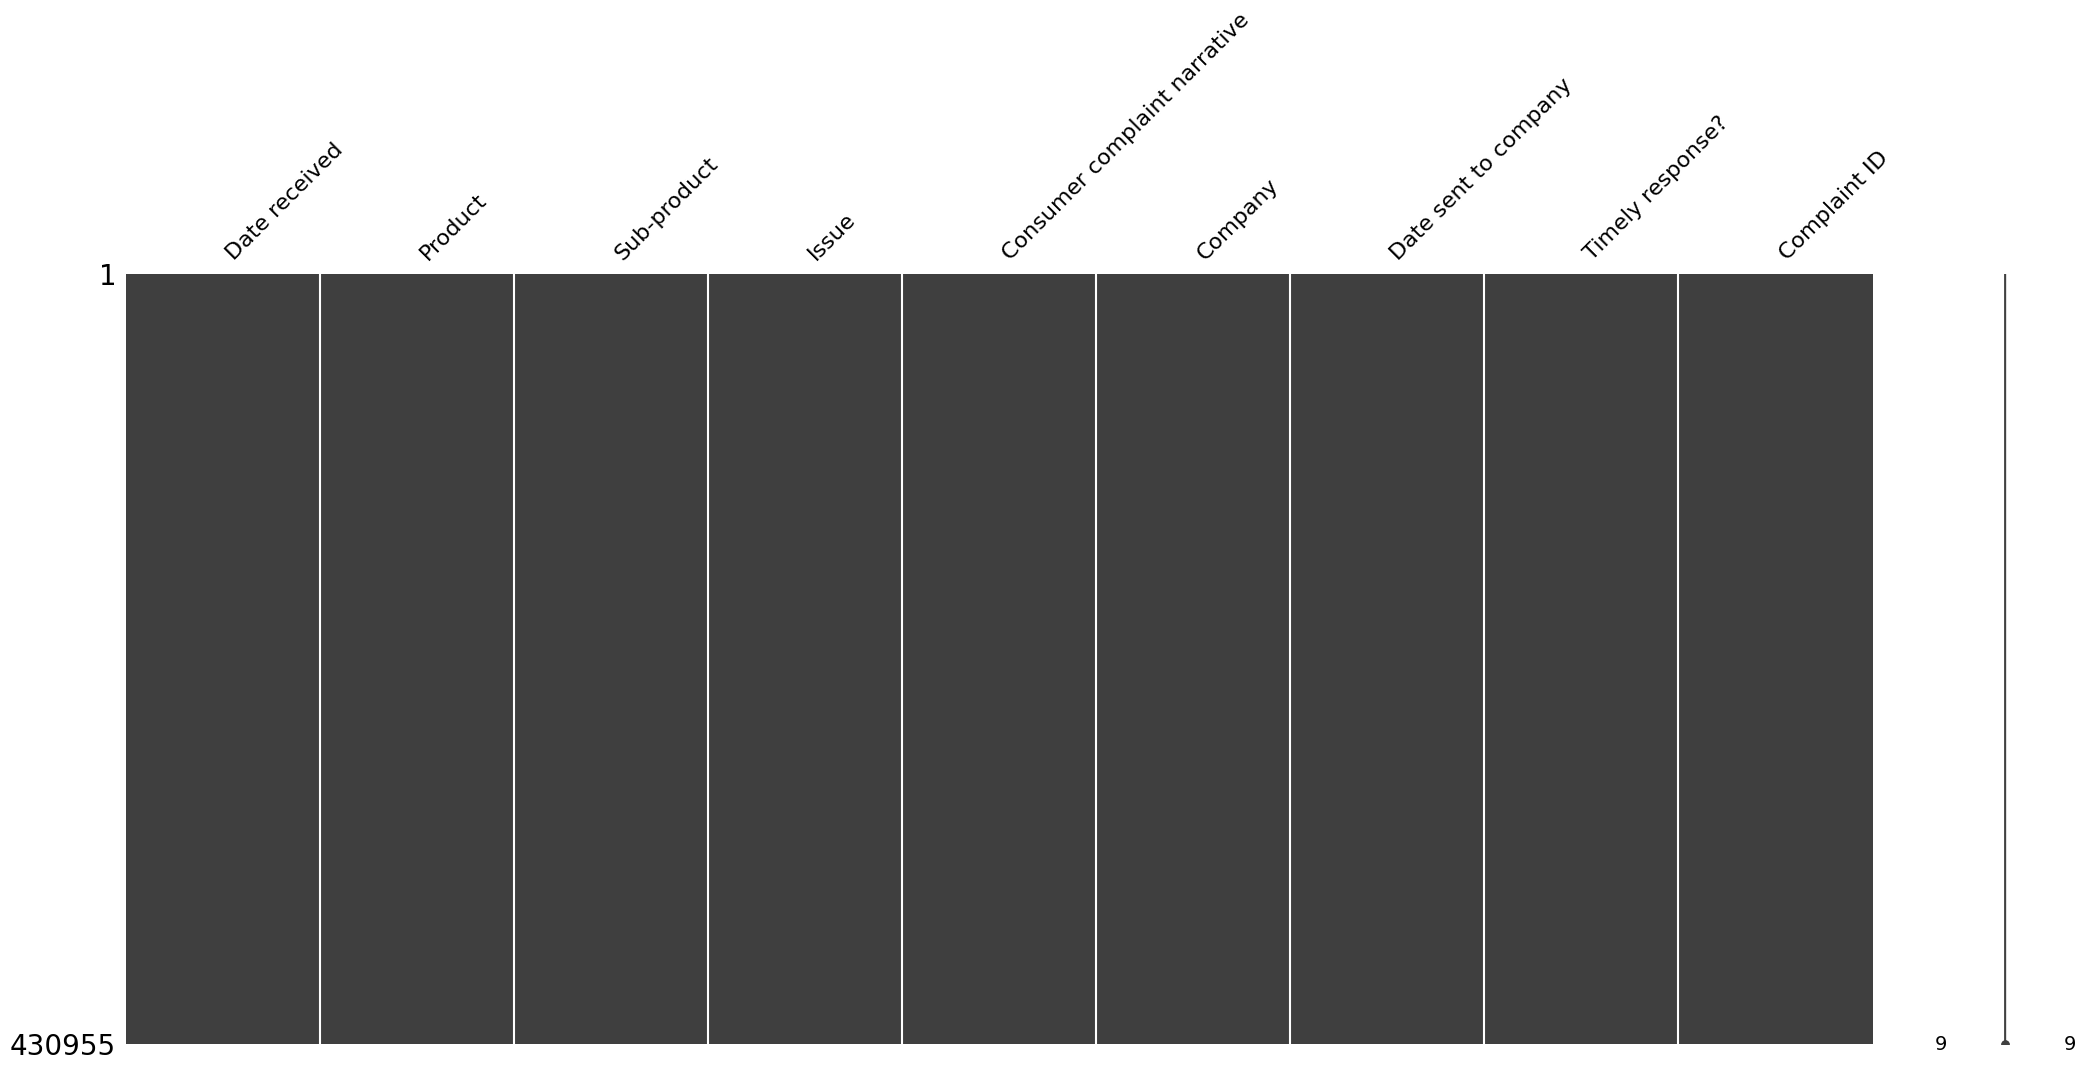

In [ ]:
import missingno as msno
msno.matrix(df1);

In [ ]:
df1.head(5)

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,Date sent to company,Timely response?,Complaint ID
710,2024-08-12,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,I am contacting you regarding fraudulent perso...,"EQUIFAX, INC.",2024-08-12,Yes,9767785
851,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Formal Complaint Regarding Inaccurate Reportin...,Experian Information Solutions Inc.,2024-07-24,Yes,9604923
1087,2024-09-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Under 15 USC 1681i ( a ) ( 1 ) ( A ) subject t...,Experian Information Solutions Inc.,2024-09-20,Yes,10188781
2303,2024-09-25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,XX/XX/XXXX Subject : Complaint Regarding Inacc...,Experian Information Solutions Inc.,2024-09-25,Yes,10233037
2330,2024-10-02,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,The presence of this account has caused me sig...,Experian Information Solutions Inc.,2024-10-02,Yes,10314140


##1.3 Summary table of product complaints

The dataset shows that the "Credit reporting or other personal consumer reports" having the highest complaints, followed by "Debt collection" and "Credit card".

In [ ]:
# Count occurrences of each product and create a table
product_counts_table = df1['Product'].value_counts().reset_index()
product_counts_table.columns = ['Product', 'Number of Complaints']


print(product_counts_table.to_string(index=True))


                                                    Product  Number of Complaints
0       Credit reporting or other personal consumer reports                338687
1                                           Debt collection                 36745
2                                               Credit card                 17753
3                               Checking or savings account                 14676
4                                                  Mortgage                  6015
5        Money transfer, virtual currency, or money service                  4828
6                                              Student loan                  3746
7                                     Vehicle loan or lease                  3644
8   Payday loan, title loan, personal loan, or advance loan                  2489
9                                              Prepaid card                  1660
10                                Debt or credit management                   712


##1.4 Summary table of sub-product counts

The complaints are related to 55 sub-products, with "Credit reporting" having the highest count, by "General-purpose credit card or charge card" and " Checking account". It's important to note that the sub-product category "I do not know" represents cases where a product does not have a specific sub-product associated.

In [ ]:
# Count occurrences of each sub-product and create a table
subproduct_counts_table = df1['Sub-product'].value_counts().reset_index()
subproduct_counts_table.columns = ['Sub-product', 'Count']


print(subproduct_counts_table.to_string(index=True))

                                         Sub-product   Count
0                                   Credit reporting  336628
1                                      I do not know   18000
2         General-purpose credit card or charge card   15257
3                                   Checking account   11708
4                                   Credit card debt    6737
5                                         Other debt    3683
6                         Conventional home mortgage    3553
7                                               Loan    3153
8                                  Store credit card    2496
9                     Federal student loan servicing    2374
10                           Telecommunications debt    2292
11                                       Rental debt    2166
12                    Other personal consumer report    2059
13                                      Medical debt    1790
14                          Mobile or digital wallet    1739
15                      

##1.5 Summary table of issue counts

The dataset lists 87 "Issues" which are types of problems consumers experience with financial products. The top issue, "Incorrect information on your report," followed by "Improper use of your report" and "Problem with a company's investigation into an existing problem".

In [ ]:
issue_counts_table = df1['Issue'].value_counts().reset_index()
issue_counts_table.columns = ['Issue', 'Count']
print(issue_counts_table.to_string(index=True))

                                                                              Issue   Count
0                                              Incorrect information on your report  163133
1                                                       Improper use of your report   95840
2                   Problem with a company's investigation into an existing problem   78793
3                                                 Attempts to collect debt not owed   16680
4                                                   Written notification about debt   12081
5                                                               Managing an account    8298
6                                   Problem with a purchase shown on your statement    3987
7                                                    Trouble during payment process    3288
8                               Took or threatened to take negative or legal action    2634
9                                                False statements or representat

In [ ]:
from google.colab import files

# Extract unique values for the specified columns
unique_values = df1[['Product', 'Sub-product', 'Issue']].drop_duplicates()

# Save the unique values DataFrame as a CSV
unique_values.to_csv('unique_values.csv', index=False)

# Download the file
files.download('unique_values.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Part 2: Implementation of AI classification model.

We selected GPT-4o-mini for its proven capability in understanding and generating human-like text. GPT-4’s extensive training on diverse datasets makes it appropriate for understanding the language often found in customer complaints, which is crucial for accurate classification.

The code look for retrieve unique product categories (catpro) and sub-product categories (catsubpro) from the dataset, which helps define the classification scope.

In [ ]:
catpro = df['Product'].unique()

In [ ]:
catpro[:1]

array(['Debt collection'], dtype=object)

In [ ]:
catsubpro = df['Sub-product'].unique()

In [ ]:
catsubpro.tolist()

['Credit card debt',
 'Credit reporting',
 'Conventional home mortgage',
 'Checking account',
 'Domestic (US) money transfer',
 'Credit repair services',
 'Other type of mortgage',
 'General-purpose credit card or charge card',
 'Home equity loan or line of credit (HELOC)',
 'Loan',
 'Other debt',
 'General-purpose prepaid card',
 'Lease',
 'Medical',
 'Personal line of credit',
 'Other personal consumer report',
 'Private student loan',
 'Other bank product/service',
 'FHA mortgage',
 'Medical debt',
 'Conventional fixed mortgage',
 'Mobile or digital wallet',
 'I do not know',
 'International money transfer',
 'Vehicle loan',
 'Other (i.e. phone, health club, etc.)',
 'VA mortgage',
 'Payday loan',
 'Credit card',
 'Store credit card',
 'Federal student loan servicing',
 'Savings account',
 'CD (Certificate of Deposit)',
 'Installment loan',
 'Other mortgage',
 'Other banking product or service',
 'Vehicle lease',
 'Auto debt',
 'Conventional adjustable mortgage (ARM)',
 'Payday loan

In [ ]:
!pip install openai
!pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


###2.1 Classification of issues into their respective sub-product categories

This code explores the model's ability to classify the sub-product of each complaint, beginning with a sample of 100 complaints. The code sends each complaint sample to the GPT-4o-mini model, instructing it to classify complaints based on predefined sub-product categories.  

In [ ]:
  from openai import OpenAI
  from google.colab import userdata
  import os
  import pandas as pd

  # Loading API Key
  my_secret_key = userdata.get('MyOpenAIKey')
  os.environ["OPENAI_API_KEY"] = my_secret_key

  # Initialize OpenAI client
  client = OpenAI()

In [ ]:
issue_desc = df1['Consumer complaint narrative'].sample(100, random_state=42).reset_index(drop=True)

## storage sample information for test accuracy
issue_desc_sample = df1['Consumer complaint narrative'].sample(100, random_state=42)
issue_desc = issue_desc_sample.reset_index(drop=True)
original_indices = issue_desc_sample.index
subproduct_sample = df1.loc[original_indices, 'Sub-product'].reset_index(drop=True)

classified_data = []

for issue_desc1 in issue_desc:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": f"You are a financial expert who classifies customer complaints based on these possible categories: {catsubpro.tolist()}. Respond with the exact category as written there."},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}' Please classify it accordingly. Respond with the exact category as written in this list: {catsubpro.tolist()}."}
        ],
        max_tokens=30,
        temperature=0.2
    )

    # Extract category assigned by OpenAI
    assigned_category = response.choices[0].message.content.strip()

    # Append the complaint and its assigned category to the list
    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Category": assigned_category
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

# Display the DataFrame
##print(df_classified)

We got an accuracy score of around 0.84 which indicates the model performs well, correctly classifying 84% of the complaints. This initial classification of products might helps streamline the routing of complaints by accurately categorizing them according to the specific product type. By doing so, complaints are automatically directed to the appropriate team specializing in each product category, reducing manual sorting and ensuring that cases reach the right experts faster.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
accuracy = accuracy_score(subproduct_sample.tolist(), df_classified['Assigned Category'].tolist())
print("Accuracy:", accuracy)

Accuracy: 0.85


## 2.2 Classifying customer complaints by issue categories

In the previous section, we evaluated how well the model categorizes complaints by sub-product, which helps streamline the routing process and enables faster response times by directing complaints to the relevant teams. Building on this, we’re now taking it a step further to determine if the model can accurately categorize complaints by specific issues, adding another layer of precision.

In [ ]:
## storage sample information for test accuracy
issue_sample = df1.loc[original_indices, 'Issue'].reset_index(drop=True)

issue = df['Issue'].unique()

classified_data = []

# Loop through each complaint, get the OpenAI response, and store it in the list
for issue_desc1 in issue_desc:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on this issues categories: {issue.tolist()}."
                f"Respond with the exact category as written there."
               )},

            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )


    # Extract category assigned by OpenAI
    assigned_category = response.choices[0].message.content.strip()

    # Append the complaint and its assigned category to the list
    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Category": assigned_category
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

# Display the DataFrame
#print(df_classified)


We got an accuracy of 0.16 in classifying complaints by specific issues. This low accuracy indicates that the model struggles with this level of detailed classification, underscoring the need for further refinement.

In [ ]:
accuracy = accuracy_score(issue_sample.tolist(), df_classified['Assigned Category'].tolist())
print("Accuracy:", accuracy)

Accuracy: 0.1


#Part 3: Model improvements

## 3.1 Multi-step classification of customer complaints into sub-product and issue categories

To improve classification accuracy, we first tried to identy the sub-product and then the associated issue.

The model iterates through each complaint to classify it by sub-product first. Based on the assigned sub-product, the model then attempts to classify the complaint into a specific issue within that sub-product category.



In [ ]:
subproduct_categories = df1['Sub-product'].unique()
issue_categories = df1['Issue'].unique()

## storage sample information to test accuracy
subproduct_sample = df1.loc[original_indices, 'Sub-product'].reset_index(drop=True)
issue_sample = df1.loc[original_indices, 'Issue'].reset_index(drop=True)


classified_data = []


for issue_desc1 in issue_desc:
    ###classify by Sub-product
    response_subproduct = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Sub-product categories: {subproduct_categories.tolist()}. "
                "Respond with the exact sub-product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    ### extract sub-product category
    assigned_subproduct = response_subproduct.choices[0].message.content.strip()

    ### Identify sub-product to classify the issue
    response_issue = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints under the '{assigned_subproduct}' sub-product. "
                f"Based on this sub-product, classify the complaint into one of these specific issues: {issue_categories.tolist()}. "
                "Respond with the exact issue as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract issue category
    assigned_issue = response_issue.choices[0].message.content.strip()

    # Append the complaint, sub-product, and issue to the list
    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Sub-product": assigned_subproduct,
        "Assigned Issue": assigned_issue
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

The results show that the sub-product classification has an accuracy of 0.85, indicating that the model is effective at correctly categorizing complaints by sub-product. However, the issue classification accuracy remains low at 0.12, highlighting the challenge of distinguishing detailed issues even within narrowed sub-product contexts.

In [ ]:
# Accuracy for sub-product classification
accuracy = accuracy_score(subproduct_sample.tolist(), df_classified['Assigned Sub-product'].tolist())
print("Sub-product classification accuracy:", accuracy)

# Accuracy for issue classification
accuracy = accuracy_score(issue_sample.tolist(), df_classified['Assigned Issue'].tolist())
print("Issue classification accuracy:", accuracy)


Sub-product classification accuracy: 0.83
Issue classification accuracy: 0.22


## 3.2 Multi-step classification of customer complaints into product, sub-product and issue categories

This approach introduces a new classification level for Product, creating a hierarchical process that categorizes complaints by Product first, followed by Sub-product, and finally Issue

In [ ]:
# Define unique categories for classification levels
product_categories = df1['Product'].unique()
subproduct_categories = df1['Sub-product'].unique()
issue_categories = df1['Issue'].unique()

# Store true labels for accuracy testing
product_sample = df1.loc[original_indices, 'Product'].reset_index(drop=True)
subproduct_sample = df1.loc[original_indices, 'Sub-product'].reset_index(drop=True)
issue_sample = df1.loc[original_indices, 'Issue'].reset_index(drop=True)

classified_data = []

for issue_desc1 in issue_desc:
    ### Classify by Product
    response_product = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Product categories: {product_categories.tolist()}. "
                "Respond with the exact product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract assigned product category
    assigned_product = response_product.choices[0].message.content.strip()

    ### Classify by Sub-product based on the assigned Product
    response_subproduct = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints fisrt under the '{assigned_product}' product. "
                f"Based on this product, classify the complaint into one of these specific sub-products: {subproduct_categories.tolist()}. "
                "Respond with the exact sub-product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract assigned sub-product category
    assigned_subproduct = response_subproduct.choices[0].message.content.strip()

    ### Classify by Issue based on the assigned Sub-product
    response_issue = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints under the '{assigned_subproduct}' sub-product. "
                f"Based on this sub-product, classify the complaint into one of these specific issues: {issue_categories.tolist()}. "
                "Respond with the exact issue as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract assigned issue category
    assigned_issue = response_issue.choices[0].message.content.strip()

    # Append the complaint, product, sub-product, and issue to the list
    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Product": assigned_product,
        "Assigned Sub-product": assigned_subproduct,
        "Assigned Issue": assigned_issue
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

# Calculate accuracy for each classification level
product_accuracy = accuracy_score(product_sample.tolist(), df_classified['Assigned Product'].tolist())
subproduct_accuracy = accuracy_score(subproduct_sample.tolist(), df_classified['Assigned Sub-product'].tolist())
issue_accuracy = accuracy_score(issue_sample.tolist(), df_classified['Assigned Issue'].tolist())



The hierarchical classification shows strong accuracy for product (0.85) and subproduct (0.84), which might improve the routing process. However, issue classification accuracy remains low at 0.1, indicating further improvements are needed to distinguish specific issues accurately.

In [ ]:
# Display the DataFrame and accuracy results
#print(df_classified)
print("Product Classification Accuracy:", product_accuracy)
print("Sub-product Classification Accuracy:", subproduct_accuracy)
print("Issue Classification Accuracy:", issue_accuracy)

Product Classification Accuracy: 0.93
Sub-product Classification Accuracy: 0.84
Issue Classification Accuracy: 0.25


##3.3 Complaint classification with filtered categories

Unlike prior methods that classified complaints more independently, this model starts by categorizing complaints at the broad Product level, which constrains the options for the next stages. The Sub-product classification then only considers categories relevant to the identified Product, refining the choices and enhancing accuracy. Finally, with both product and subproduct determined, the model narrows the Issue classification to a focused set of options associated specifically with the selected product and subproduct

In [ ]:
# Define unique categories for each classification level
product_categories = df1['Product'].unique()

# Store true labels for accuracy testing
product_sample = df1.loc[original_indices, 'Product'].reset_index(drop=True)
subproduct_sample = df1.loc[original_indices, 'Sub-product'].reset_index(drop=True)
issue_sample = df1.loc[original_indices, 'Issue'].reset_index(drop=True)

classified_data = []

for issue_desc1 in issue_desc:
    ### Step 1: Classify by Product
    response_product = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Product categories: {product_categories.tolist()}. "
                "Respond with the exact product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract assigned Product category
    assigned_product = response_product.choices[0].message.content.strip()

    ### Step 2: Classify by Sub-product based on the assigned Product
    # Filter sub-product options relevant to the assigned product
    subproduct_options = df1[df1['Product'] == assigned_product]['Sub-product'].unique()

    response_subproduct = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Sub-product categories under the product '{assigned_product}': {subproduct_options.tolist()}. "
                "Respond with the exact sub-product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract assigned Sub-product category
    assigned_subproduct = response_subproduct.choices[0].message.content.strip()

    ### Step 3: Classify by Issue based on the assigned Product and Sub-product
    # Filter issue options relevant to the assigned product and sub-product
    issue_options = df1[(df1['Product'] == assigned_product) & (df1['Sub-product'] == assigned_subproduct)]['Issue'].unique()

    response_issue = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Issue categories under the product '{assigned_product}' and sub-product '{assigned_subproduct}': {issue_options.tolist()}. "
                "Respond with the exact issue as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    # Extract assigned Issue category
    assigned_issue = response_issue.choices[0].message.content.strip()

    # Append the complaint, product, sub-product, and issue to the list
    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Product": assigned_product,
        "Assigned Sub-product": assigned_subproduct,
        "Assigned Issue": assigned_issue
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

# Calculate accuracy for each classification level
product_accuracy = accuracy_score(product_sample.tolist(), df_classified['Assigned Product'].tolist())
subproduct_accuracy = accuracy_score(subproduct_sample.tolist(), df_classified['Assigned Sub-product'].tolist())
issue_accuracy = accuracy_score(issue_sample.tolist(), df_classified['Assigned Issue'].tolist())

# Display the DataFrame and accuracy results
#print(df_classified)
print("Product Classification Accuracy:", product_accuracy)
print("Sub-product Classification Accuracy:", subproduct_accuracy)
print("Issue Classification Accuracy:", issue_accuracy)


Product Classification Accuracy: 0.92
Sub-product Classification Accuracy: 0.84
Issue Classification Accuracy: 0.43


This approach achieved a product and subproduct classification accuracy consistent with earlier results. The most notable improvement is in Issue classification accuracy, which increased to 0.4. While still low, this increase suggests that the step-by-step funneling approach is helping the model more accurately identify specific issues.

##3.3 Group Issues under broader umbrella categorie

We mapped the product, sub-product, and issue from a dataset to their corresponding broader category using a pre-defined mapping. This mapping was created with the help of ChatGPT. As a result, we classified 87 types of issues into 21 broader categories, aiming to improve the classification process for these issues.

In [ ]:
from openai import OpenAI
import pandas as pd
import os
from sklearn.metrics import accuracy_score

# Load datasets

umbrella_link = "https://raw.githubusercontent.com/JeanJMH/Financial_Classification/refs/heads/main/Classification_data_fully_classified_Umbrella.csv"
umbrella_data = pd.read_csv(umbrella_link)


# Create a mapping from the umbrella dataset
broader_category_mapping = umbrella_data.set_index(['Product', 'Sub-product', 'Issue'])['Broader_Category'].to_dict()

# Sampling logic from df1
issue_desc_sample = df1['Consumer complaint narrative'].sample(10, random_state=42)
issue_desc = issue_desc_sample.reset_index(drop=True)
original_indices = issue_desc_sample.index
product_sample = df1.loc[original_indices, 'Product'].reset_index(drop=True)
subproduct_sample = df1.loc[original_indices, 'Sub-product'].reset_index(drop=True)
issue_sample = df1.loc[original_indices, 'Issue'].reset_index(drop=True)

# Map Broader_Category to the sample
sample_data = pd.DataFrame({
    'Product': product_sample,
    'Sub-product': subproduct_sample,
    'Issue': issue_sample
})
sample_data['Broader_Category'] = sample_data.apply(
    lambda row: broader_category_mapping.get((row['Product'], row['Sub-product'], row['Issue'])), axis=1
)

# Extract the broader category from the sample for accuracy testing
broader_category_sample = sample_data['Broader_Category'].reset_index(drop=True)

classified_data = []

# Iterate directly over issue_desc
for issue_desc1 in issue_desc:
    ### Step 1: Classify by Product
    product_categories = umbrella_data['Product'].unique()

    response_product = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Product categories: {product_categories.tolist()}. "
                "Respond with the exact product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    assigned_product = response_product.choices[0].message.content.strip()

    ### Step 2: Classify by Sub-product based on the assigned Product
    subproduct_options = umbrella_data[umbrella_data['Product'] == assigned_product]['Sub-product'].unique()

    response_subproduct = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Sub-product categories under the product '{assigned_product}': {subproduct_options.tolist()}. "
                "Respond with the exact sub-product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    assigned_subproduct = response_subproduct.choices[0].message.content.strip()

    ### Step 3: Classify by Broader_Category
    broader_category_options = umbrella_data[
        (umbrella_data['Product'] == assigned_product) &
        (umbrella_data['Sub-product'] == assigned_subproduct)
    ]['Broader_Category'].unique()

    response_broader_category = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Broader_Category categories under the product '{assigned_product}' and sub-product '{assigned_subproduct}': {broader_category_options.tolist()}. "
                "Respond with the exact broader category as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )

    assigned_broader_category = response_broader_category.choices[0].message.content.strip()

    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Product": assigned_product,
        "Assigned Sub-product": assigned_subproduct,
        "Assigned Broader_Category": assigned_broader_category
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

# Calculate accuracy for each classification level
product_accuracy = accuracy_score(product_sample.tolist(), df_classified['Assigned Product'].tolist())
subproduct_accuracy = accuracy_score(subproduct_sample.tolist(), df_classified['Assigned Sub-product'].tolist())
broader_category_accuracy = accuracy_score(broader_category_sample.tolist(), df_classified['Assigned Broader_Category'].tolist())

# Display the accuracy results
print("Product Classification Accuracy:", product_accuracy)
print("Sub-product Classification Accuracy:", subproduct_accuracy)
print("Broader Category Classification Accuracy:", broader_category_accuracy)

Product Classification Accuracy: 0.9
Sub-product Classification Accuracy: 0.8
Broader Category Classification Accuracy: 0.2


As a result, we achieved a low level of accuracy (around 0.2), which can be explained by the lack of connection between the issues and the broader categories in the classification process.

##3.4 Group Issues under broader umbrella categorie - improvement.





Unlike the previous version, this code adds an issue classification step, providing more detailed accuracy insights at that level before assigning broader categories.

In [ ]:
import pandas as pd
from openai import OpenAI
from sklearn.metrics import accuracy_score

# Load umbrella dataset
umbrella_link = "https://raw.githubusercontent.com/JeanJMH/Financial_Classification/refs/heads/main/Classification_data_fully_classified_Umbrella.csv"
umbrella_data = pd.read_csv(umbrella_link)

# Create a mapping from the umbrella dataset
broader_category_mapping = umbrella_data.set_index(['Product', 'Sub-product', 'Issue'])['Broader_Category'].to_dict()

# Sampling logic from df1
issue_desc_sample = df1['Consumer complaint narrative'].sample(100, random_state=42)
issue_desc = issue_desc_sample.reset_index(drop=True)
original_indices = issue_desc_sample.index
product_sample = df1.loc[original_indices, 'Product'].reset_index(drop=True)
subproduct_sample = df1.loc[original_indices, 'Sub-product'].reset_index(drop=True)
issue_sample = df1.loc[original_indices, 'Issue'].reset_index(drop=True)

# Map Broader_Category to the sample for accuracy testing
sample_data = pd.DataFrame({
    'Product': product_sample,
    'Sub-product': subproduct_sample,
    'Issue': issue_sample
})
sample_data['Broader_Category'] = sample_data.apply(
    lambda row: broader_category_mapping.get((row['Product'], row['Sub-product'], row['Issue'])), axis=1
)

# Extract the broader category from the sample
broader_category_sample = sample_data['Broader_Category'].reset_index(drop=True)

classified_data = []

# Iterate through the sampled descriptions
for issue_desc1 in issue_desc:
    ### Step 1: Classify by Product
    product_categories = umbrella_data['Product'].unique()

    response_product = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Product categories: {product_categories.tolist()}. "
                "Respond with the exact product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )
    assigned_product = response_product.choices[0].message.content.strip()

    ### Step 2: Classify by Sub-product
    subproduct_options = umbrella_data[umbrella_data['Product'] == assigned_product]['Sub-product'].unique()

    response_subproduct = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Sub-product categories under the product '{assigned_product}': {subproduct_options.tolist()}. "
                "Respond with the exact sub-product as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )
    assigned_subproduct = response_subproduct.choices[0].message.content.strip()

    ### Step 3: Classify by Issue
    issue_options = umbrella_data[
        (umbrella_data['Product'] == assigned_product) &
        (umbrella_data['Sub-product'] == assigned_subproduct)
    ]['Issue'].unique()

    response_issue = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": (
                f"You are a financial expert who classifies customer complaints based on these Issue categories under the product '{assigned_product}' and sub-product '{assigned_subproduct}': {issue_options.tolist()}. "
                "Respond with the exact issue as written there."
            )},
            {"role": "user", "content": f"This is my issue: '{issue_desc1}'."}
        ],
        max_tokens=20,
        temperature=0.1
    )
    assigned_issue = response_issue.choices[0].message.content.strip()

    ### Step 4: Assign Broader_Category
    assigned_broader_category = broader_category_mapping.get(
        (assigned_product, assigned_subproduct, assigned_issue), "Unknown"
    )

    # Append the classifications to the list
    classified_data.append({
        "Complaint": issue_desc1,
        "Assigned Product": assigned_product,
        "Assigned Sub-product": assigned_subproduct,
        "Assigned Issue": assigned_issue,
        "Assigned Broader_Category": assigned_broader_category
    })

# Convert the list of dictionaries to a DataFrame
df_classified = pd.DataFrame(classified_data)

# Calculate accuracy for each classification level
product_accuracy = accuracy_score(product_sample.tolist(), df_classified['Assigned Product'].tolist())
subproduct_accuracy = accuracy_score(subproduct_sample.tolist(), df_classified['Assigned Sub-product'].tolist())
issue_accuracy = accuracy_score(issue_sample.tolist(), df_classified['Assigned Issue'].tolist())
broader_category_accuracy = accuracy_score(broader_category_sample.tolist(), df_classified['Assigned Broader_Category'].tolist())

# Display the DataFrame and accuracy results
#print(df_classified)
print("Product Classification Accuracy:", product_accuracy)
print("Sub-product Classification Accuracy:", subproduct_accuracy)
print("Issue Classification Accuracy:", issue_accuracy)
print("Broader Category Classification Accuracy:", broader_category_accuracy)

Product Classification Accuracy: 0.92
Sub-product Classification Accuracy: 0.84
Issue Classification Accuracy: 0.42
Broader Category Classification Accuracy: 0.62


As a result, we found that the classification process using umbrella categorization improved the accuracy of the classifications. However, this approach requires further refinement because we did not consider formal definitions, which could enhance the categorization or validate the broader categories created with ChatGPT.